In [2]:
# https://github.com/miladfa7/Image-Classification-Transfer-Learning/blob/master/ResNet_image_classification.ipynbIn 

import os
import tensorflow as tf #tf 2.0.0
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_data_gen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0,
    rescale=1./255
)

valid_data_gen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0,
    rescale=1./255)

In [9]:
dataset_dir = "classification data"
Batch_size = 8
img_h = 256
img_w = 256
num_classes=2
classes = ['spacesuit', # 0
           'nosuit'# 1
          ]

# Training
SEED = 1234
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_directory(
    training_dir,
    target_size=(256, 256),
    batch_size=Batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
) # targets are directly converted into one-hot vectors

# Test
valid_dir = os.path.join(dataset_dir, 'test')
valid_gen = valid_data_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=Batch_size, 
    classes=classes,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 8768 images belonging to 2 classes.
Found 3577 images belonging to 2 classes.


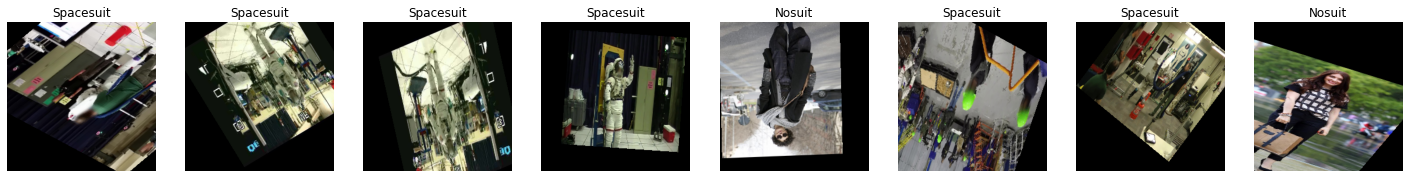

In [11]:
CLASS_NAMES = np.array(['spacesuit', 'nosuit'], dtype='<U10')

import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(25,20))
    for n in range(8):
        ax = plt.subplot(1,8,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [12]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

234561536/234545216 [==============================] - 75s 0us/step


In [13]:
x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(units=2, activation='softmax')(x)

model = Model(ResNet_model.input, output)

In [14]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.4, min_lr=0.0001)
callbacks = [lrr]
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit_generator(generator=train_gen,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_gen,validation_steps=STEP_SIZE_VALID,epochs=10,callbacks=callbacks)

Epoch 1/10


<ipython-input-14-99e81049ed5f>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(generator=train_gen,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_gen,validation_steps=STEP_SIZE_VALID,epochs=10,callbacks=callbacks)


1096/1096 [==============================] - 188s 165ms/step - loss: 0.0754 - accuracy: 0.9849 - val_loss: 0.0019 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 2/10
1096/1096 [==============================] - 180s 164ms/step - loss: 0.0315 - accuracy: 0.9924 - val_loss: 0.1135 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 3/10
1096/1096 [==============================] - 357s 326ms/step - loss: 0.1264 - accuracy: 0.9928 - val_loss: 0.0071 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 4/10
1096/1096 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9978
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
1096/1096 [==============================] - 250s 228ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 0.0030 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 5/10
1096/1096 [==============================] - 185s 169ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 6.9791e-04 - val_accuracy: 0.9997 - lr: 4.0000e-04
Epoch 6/10
1096/1096 [=============

In [15]:
model.save('keras_model_imagenet')

INFO:tensorflow:Assets written to: keras_model_imagenet/assets


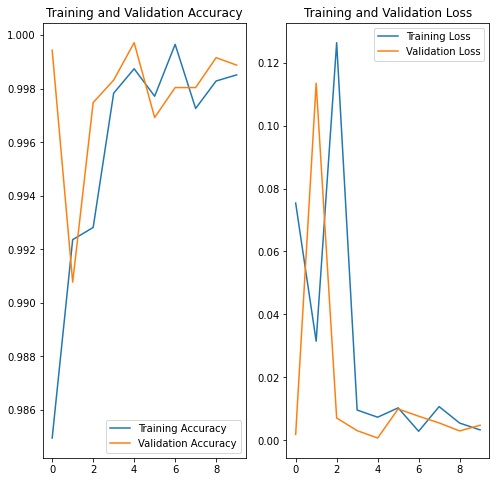

In [17]:
import matplotlib.pyplot as plt
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs_range = range(10)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)

447/447 [==============================] - 52s 115ms/step - loss: 0.0064 - accuracy: 0.9978


[0.006400211714208126, 0.9977628588676453]

In [19]:
preds = model.predict(valid_gen,verbose=1)
y_preds = np.argmax(preds,axis=1)
y_preds

448/448 [==============================] - 53s 114ms/step


array([0, 0, 0, ..., 1, 1, 1])

In [20]:
y_trues = valid_gen.classes
y_trues

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [21]:
len(y_preds),len(y_trues)

(3577, 3577)

In [22]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_trues, y_preds)
print("Node \t precision \t recall \t fscore \t support")
for i,dat in enumerate(zip(precision,recall,fscore,support)):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i,dat[0],dat[1],dat[2],dat[3]))

Node 	 precision 	 recall 	 fscore 	 support
0 	 0.9996 	 0.9981 	 0.9988 	 2577.0000
1 	 0.9950 	 0.9990 	 0.9970 	 1000.0000


In [23]:
from sklearn.metrics import f1_score
f1_score(y_trues, y_preds,average='weighted')

0.9983236393421483

In [24]:
# # Test
# test_dir = dataset_dir
# test_data_gen = ImageDataGenerator(rescale=1./255)
# test_gen = test_data_gen.flow_from_directory(
#     test_dir,
#     classes=['val'],
#     target_size=(256, 256),
#     seed=SEED,
#     shuffle=False
# )

# test_gen.reset()
# pred=model.predict(test_gen,verbose=1)
# predicted_class_indices=np.argmax(pred,axis=1)
# predictions = [k for k in predicted_class_indices]
# sum([1 for p in predictions if p ==0])

In [28]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (256, 256, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = load('test/images/346998.jpg')
np.argmax(model.predict(image),axis=1)[0]

0